In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

# Set the default font size for text elements (e.g., titles, labels)
sns.set() # default from sns is pretties (:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'


# Set filename start. Create the folder if gone
filepath_location = "Figures/b/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])


# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

# Import split and MSELoss. All descent methods.
from Code.data_handling import train_test_split, load_MNIST_28
from Code.utilities import MSELoss_method, plot_test_results, cross_entropy_loss_method
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam

from jax import jit, nn, grad, device_get
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np



#In testing
from Code.convolutional import convolutional_model_old, _beta_init_conv, get_convolutional_model

c:\Users\Eirik\Desktop\UIO\FYSSTK\Project3_FYS_STK4155\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


inputs = (n_inputs, pixel_width, pixel_height, depth) = (1797, 8, 8, 1)
labels = (n_inputs) = (1797,)


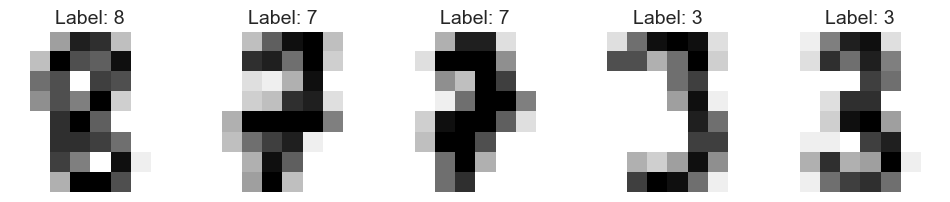

In [2]:
# import necessary packages
import numpy as np
from sklearn import datasets

# ensure the same random numbers appear every time
np.random.seed(0)

# display images in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)


# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

# RGB images have a depth of 3
# our images are grayscale so they should have a depth of 1
inputs = inputs[:,:,:,np.newaxis]

print("inputs = (n_inputs, pixel_width, pixel_height, depth) = " + str(inputs.shape))
print("labels = (n_inputs) = " + str(labels.shape))


# choose some random images to display
n_inputs = len(inputs)
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[random_indices[i]])
plt.show()

In [25]:
X = inputs.reshape((inputs.shape[0], inputs.shape[1], inputs.shape[2]))

# Convert the numbers in y to arrays with 0's and 1's corresponding to classes 
y = labels.reshape((labels.shape[0]))
y = np.eye(10)[y]


# Split in test and train
X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=None)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# # download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=False)

X_train, y_train, X_test, y_test = X_train[:1500], y_train[:1500], X_test[:300], y_test[:300]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# print(X_train.shape)

(1438, 8, 8)
(359, 8, 8)
(1438, 10)
(359, 10)
(1500, 28, 28)
(300, 28, 28)
(1500, 10)
(300, 10)


In [26]:
window_size = 3
beta0 = {"conv_window_1":np.random.normal(0, 1, (1, window_size, window_size)), "W2":np.random.normal(0, 1, (64, 10)), "b2":np.random.normal(0, 1, (1, 10))}


def conv_model(beta, X):
    out = jsp.signal.convolve(X.copy(), beta["conv0"], mode="full")
    out = jsp.signal.convolve(out, beta["conv1"], mode="full")
    out = jsp.signal.convolve(out, beta["conv2"], mode="full")
    out = jsp.signal.convolve(out, beta["conv3"], mode="full")
    out = jnp.resize(out, (out.shape[0], out.shape[1]*out.shape[2]))
    out = nn.sigmoid(jnp.dot(out, beta["W_out"]) + beta["b_out"])
    return out




# Make prediction function:
def predict(model, beta, X):
    """
    Returns the predicted number for each sample in X
    """

    # Use the neural network
    y = model(beta, X)

    # Find best guess index
    predictions = jnp.array([jnp.argmax(y_sample) for y_sample in y])

    return predictions



# Define new accuracy function
def accuracy_method(model):
    """
    Returns function for evaluating accuracy for given model
    ACCURACY = percentage guessed correctly    
    """

    def accuracy_func(beta, X, y):

        # Find indeces corresponding to ground truth
        predictions_gt = jnp.array([jnp.argmax(y_sample) for y_sample in y])
        predictions    = predict(model, beta, X)

        # return 1-jnp.mean(jnp.abs(predictions_gt-predictions))
        return jnp.sum(predictions_gt == predictions) / predictions.shape[0]

    return accuracy_func





dict_keys(['conv0', 'conv1', 'W_out', 'b_out'])


100%|██████████| 300/300 [01:20<00:00,  3.72it/s]


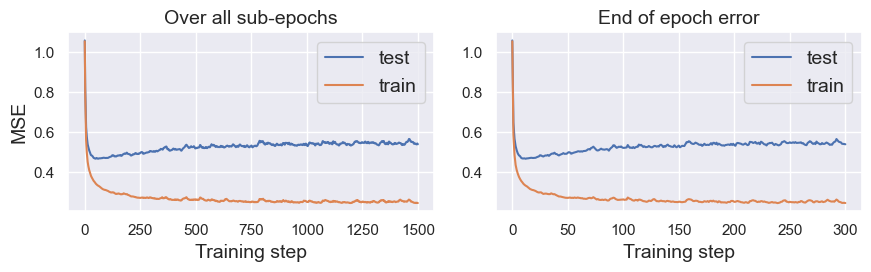

test:  0.75
train:  0.96933335


In [31]:
def single_run(X_train, X_test, y_train, y_test, lr, lam, window_size_list=[3, 4],
               epochs=300, test_index=None, plot_or_not=False):
    
    """
    Performs a training with the given parameter

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    beta0 = _beta_init_conv((X_train.shape[1], X_train.shape[2]), window_size_list)
    print(beta0.keys())
    # model = jit(get_convolutional_model(beta0))
    model = jit(convolutional_model_old)
    # model = jit(conv_model)

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    loss_func = jit(MSELoss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    # MSE loss function for evaluation
    test_func = jit(MSELoss_method(model))
    # test_func2 = jit(accuracy_method(model))
    test_funcs = [test_func]#, test_func2]

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, 
                      test_loss_func= test_funcs, lr=lr)
    result.update({"model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"][0], result["train_loss_list"][0], 5, ylabel="MSE")
        # plot_test_results(result["test_loss_list"][1], result["train_loss_list"][1], 5, ylabel="Accuracy")

    result["test_accuracy"] = accuracy_method(model)(result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_method(model)(result["beta_final"], X_train, y_train)

    return result

epochs = 300
result = single_run(X_train, X_test, y_train, y_test, lr=0.01, lam=0.0001, epochs=epochs, plot_or_not=True)

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

In [6]:
beta0 = _beta_init_conv((X_train.shape[1], X_train.shape[2]), (2, 3, 4))
model = get_convolutional_model(beta0)

